In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as plt
from tensorflow import keras
# from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from keras.metrics import Accuracy
#from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

aglo_data = pd.read_excel("included_2016_nn_dataset_input.xlsx")
aglo_data = aglo_data.drop(columns=["Datum do", 'Datum od'])


data_numeric = aglo_data.apply(pd.to_numeric, errors='coerce').dropna()

X = data_numeric.drop(columns=["Sinter.SP4.Rozsev.Under5mm.%"])
y = data_numeric["Sinter.SP4.Rozsev.Under5mm.%"]

scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1, 1))

X = scaler.fit_transform(X)

# Splitting the dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
n_features = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], 1, n_features)
X_val = X_val.reshape(X_val.shape[0], 1, n_features)
X_test = X_test.reshape(X_test.shape[0], 1, n_features)
print("X_train shape:", X_train.shape)  # Check the shape of X_train
print("X_train shape after reshaping:", X_train.shape)

X_train shape: (1617, 1, 17)
X_train shape after reshaping: (1617, 1, 17)


In [61]:
model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(None, 17)))
model.add(GRU(units=64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, None, 50)          10350     
                                                                 
 dropout_12 (Dropout)        (None, None, 50)          0         
                                                                 
 gru_10 (GRU)                (None, 100)               45600     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 56051 (218.95 KB)
Trainable params: 56051 (218.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/500
13/13 [==============================] - 5s 68ms/step - loss: 108.1015 - val_loss: 115.2018
Epoch 2/500
13/13 [==============================] - 0s 14ms/step - loss: 93.1249 - val_loss: 83.4651
Epoch 3/500
13/13 [==============================] - 0s 13ms/step - loss: 52.5358 - val_loss: 42.2507
Epoch 4/500
13/13 [==============================] - 0s 18ms/step - loss: 32.6298 - val_loss: 29.8434
Epoch 5/500
13/13 [==============================] - 0s 13ms/step - loss: 21.3572 - val_loss: 20.8234
Epoch 6/500
13/13 [==============================] - 0s 17ms/step - loss: 17.6443 - val_loss: 20.2819
Epoch 7/500
13/13 [==============================] - 0s 16ms/step - loss: 15.7264 - val_loss: 18.5517
Epoch 8/500
13/13 [==============================] - 0s 17ms/step - loss: 14.5947 - val_loss: 18.4627
Epoch 9/500
13/13 [==============================] - 0s 14ms/step - loss: 14.2459 - val_loss: 17.6434
Epoch 10/500
13/13 [==============================] - 0s 21ms/step - loss: 13.54

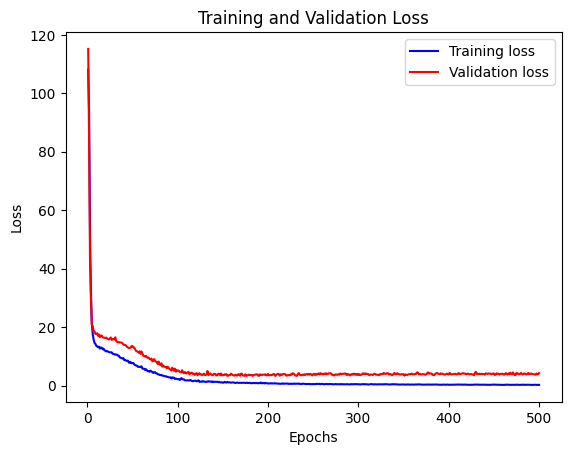

In [63]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss progression
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

19/19 [==============================] - 0s 2ms/step - loss: 2.5585
Test Loss: 2.5585408210754395


In [65]:
predictions = model.predict(X_test)

19/19 [==============================] - 1s 3ms/step


In [66]:
predictions_train = model.predict(X_train)

51/51 [==============================] - 0s 4ms/step


In [67]:
predictions_val = model.predict(X_val)

22/22 [==============================] - 0s 3ms/step


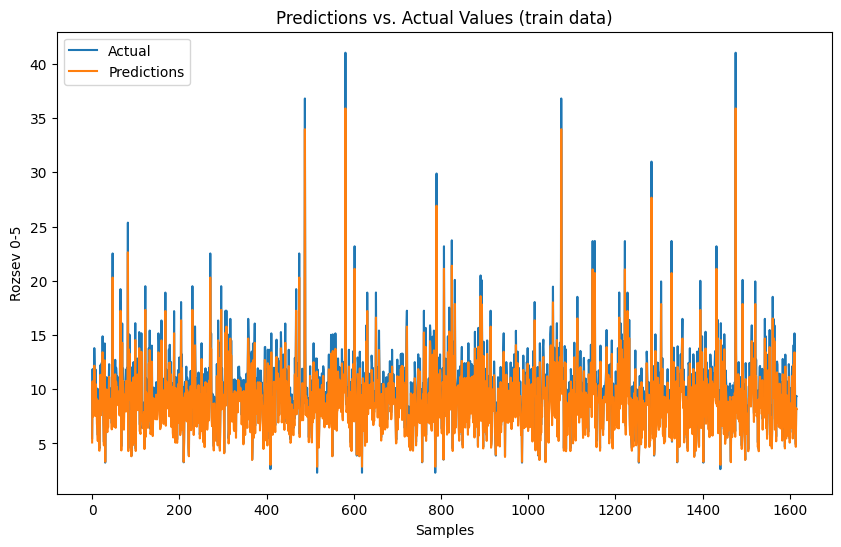

In [68]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_train.values, label='Actual')
plt.plot(predictions_train, label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Rozsev 0-5')
plt.title('Predictions vs. Actual Values (train data)')
plt.legend()
plt.show()

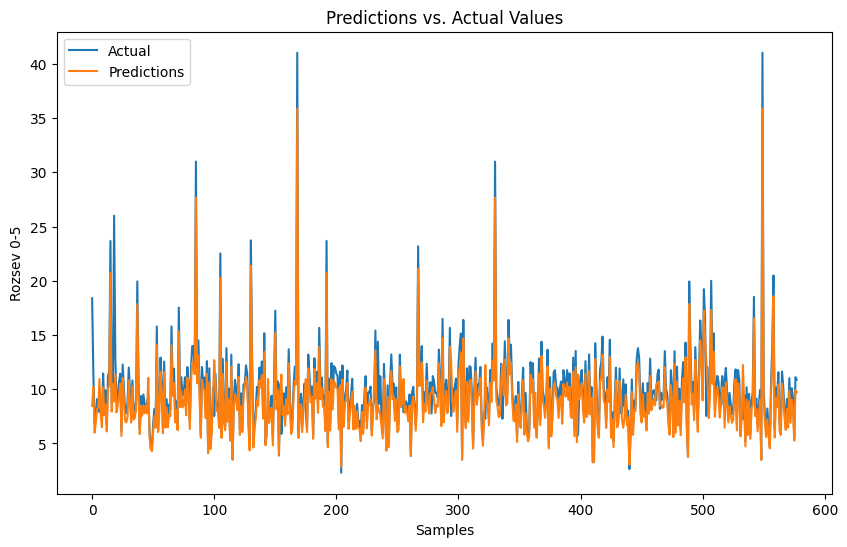

In [69]:


plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predictions')

plt.xlabel('Samples')
plt.ylabel('Rozsev 0-5')
plt.title('Predictions vs. Actual Values')
plt.legend()
plt.show()

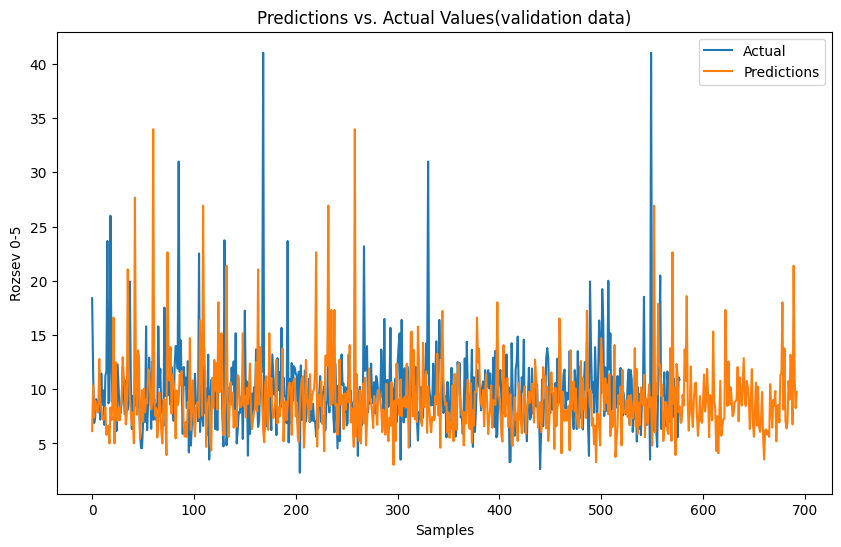

In [70]:

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions_val, label='Predictions')

plt.xlabel('Samples')
plt.ylabel('Rozsev 0-5')
plt.title('Predictions vs. Actual Values(validation data)')
plt.legend()
plt.show()

In [71]:
for i in range(len(predictions)):
    absolute_difference = abs(predictions[i] - y_test.values[i])
    if absolute_difference > 1:
        print("Predicted:", predictions[i], "\tActual:", y_test.values[i], "\tResult: Bad prediction")
    else:
        print("Predicted:", predictions[i], "\tActual:", y_test.values[i], "\tResult: Good prediction")

Predicted: [8.460853] 	Actual: 18.3899993896484 	Result: Bad prediction
Predicted: [10.215953] 	Actual: 11.460000038147 	Result: Bad prediction
Predicted: [5.9992766] 	Actual: 6.88000011444092 	Result: Good prediction
Predicted: [6.921578] 	Actual: 7.3899998664856 	Result: Good prediction
Predicted: [8.209658] 	Actual: 9.09000015258789 	Result: Good prediction
Predicted: [8.258387] 	Actual: 8.85000038146973 	Result: Good prediction
Predicted: [10.940584] 	Actual: 7.88000011444092 	Result: Bad prediction
Predicted: [7.741805] 	Actual: 8.47999954223633 	Result: Good prediction
Predicted: [6.497631] 	Actual: 7.19000005722046 	Result: Good prediction
Predicted: [10.175813] 	Actual: 11.4499998092651 	Result: Bad prediction
Predicted: [7.5962725] 	Actual: 8.56999969482422 	Result: Good prediction
Predicted: [8.579754] 	Actual: 9.89000034332275 	Result: Bad prediction
Predicted: [6.1050043] 	Actual: 6.71000003814697 	Result: Good prediction
Predicted: [10.074328] 	Actual: 11.2399997711182 	Re